### 4. Ajuste de hiperparámetros y evaluación con la muestra de test.

En la fase actual de nuestro proyecto, hemos avanzado con éxito en la selección de un modelo que consideramos adecuado para abordar la problemática en cuestión. El siguiente paso en nuestra estrategia es optimizar aún más el rendimiento de este modelo mediante la búsqueda de hiperparámetros más efectivos. Con este propósito, hemos optado por implementar una técnica avanzada conocida como Random Grid SearchCV.

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from imblearn.over_sampling import SMOTE
from itertools import product
import random
import scikitplot as skplt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, fbeta_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay
)


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Carga de datos

In [3]:
pd_fraud_train = pd.read_csv('../data/train.csv')
pd_fraud_test = pd.read_csv('../data/test.csv')

In [4]:
# Extract features (independent variables) for training from the training dataset (pd_fraud_train)
X_train = pd_fraud_train.drop('fraud_bool', axis=1)

# Extract the target variable (dependent variable) for training from the training dataset (pd_fraud_train)
y_train = pd_fraud_train['fraud_bool']

In [5]:
# Extract features (independent variables) for testing from the test dataset (pd_fraud_test)
X_test = pd_fraud_test.drop('fraud_bool', axis=1)

# Extract the target variable (dependent variable) for testing from the test dataset (pd_fraud_test)
y_test = pd_fraud_test['fraud_bool']

#### Oversampling

En este caso incorporamos la validación como parte del train, de esta manera tenemos un train con el 80% del dataset que utilizaremos para entrenar el modelo y un 20% con el test. Igual que anteriormente aplicamos oversampling al train ya que queremos ampliar el número de instancias de clase fraudulenta para dotar al train con más casos de este tipo.

In [6]:
# Set the desired oversampling ratio
desired_ratio = 0.5

# Create an instance of SMOTE with a specific random state and sampling strategy
smote = SMOTE(sampling_strategy=desired_ratio, random_state=10)

# Apply SMOTE to the training data to generate synthetic samples
X_train, y_train = smote.fit_resample(X_train, y_train)

In [7]:
# Count the occurrences of each class in the target variable (y_train)
fraud_count = pd.value_counts(y_train)

# Calculate the percentage of each class relative to the total number of samples
fraud_percentage = fraud_count / len(y_train) * 100

# Create a DataFrame to display counts and percentages
result_df = pd.DataFrame({'Count': fraud_count, 'Percentage': fraud_percentage})

# Print the resulting DataFrame, showing the count and percentage of each class
print(result_df)



             Count  Percentage
fraud_bool                    
0           791150   66.666667
1           395575   33.333333


### Ajuste de Hiperparámetros

#### Búsqueda de hiperparámetros | Grid Search vs Random Search

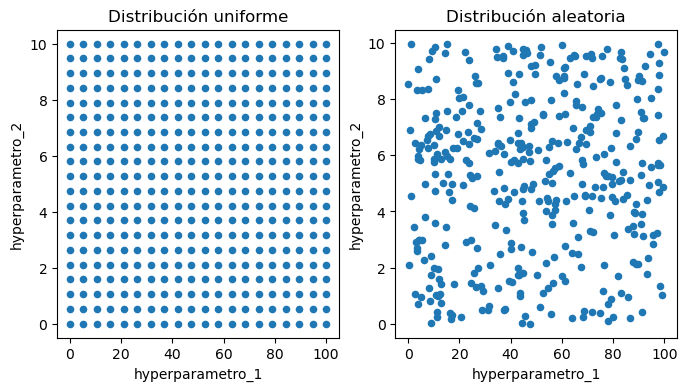

In [8]:
# Create a 1x2 grid of subplots with shared x-axis
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=False)

# Define hyperparameter grids for comprehensive and random distributions
hyperparametro_1 = np.linspace(start=0, stop=100, num=20)
hyperparametro_2 = np.linspace(start=0, stop=10, num=20)

# Generate all combinations for the comprehensive grid
combinaciones = [list(x) for x in product(hyperparametro_1, hyperparametro_2)]
combinaciones = pd.DataFrame.from_records(
    combinaciones,
    columns=['hyperparametro_1', 'hyperparametro_2']
)

# Plot the comprehensive grid on the first subplot
combinaciones.plot(
    x='hyperparametro_1',
    y='hyperparametro_2',
    kind='scatter',
    ax=axs[0]
)
axs[0].set_title('Distribución uniforme')  # Set subplot title

# Generate random hyperparameter values for the random grid
hyperparametro_1 = np.random.uniform(low=0, high=100, size=400)
hyperparametro_2 = np.random.uniform(low=0, high=10, size=400)

# Create a DataFrame with random hyperparameter values
combinaciones = pd.DataFrame(
    {'hyperparametro_1': hyperparametro_1, 'hyperparametro_2': hyperparametro_2}
)

# Plot the random grid on the second subplot
combinaciones.plot(
    x='hyperparametro_1',
    y='hyperparametro_2',
    kind='scatter',
    ax=axs[1]
)
axs[1].set_title('Distribución aleatoria')  # Set subplot title

# Show the entire plot
plt.show()


Este código es útil para entender cómo se exploran los espacios de hiperparámetros en cada método diferente,tanto en Grid Search como en Random Search, y puede ayudar a visualizar por qué la búsqueda aleatoria puede ser preferible cuando se trabaja con un gran número de hiperparámetros o cuando la evaluación de cada modelo es computacionalmente costosa.

#### Definición de hiperparámetros para Adaboost

El ajuste de hiperparámetros es un paso fundamental para mejorar el rendimiento del modelo. Los hiperparámetros son ajustes de configuración que no se aprenden de los datos, sino que deben especificarse antes del entrenamiento del modelo. La optimización de estos hiperparámetros puede influir significativamente en la capacidad del modelo para generalizar bien con datos nuevos y desconocidos.

En este contexto, nos centramos en el algoritmo AdaBoost, una popular técnica de aprendizaje ensemble que trataremos de optimizar a través de la definición de hiperparámetros

In [9]:
# Define the hyperparameter range for the AdaBoost model
param_dist_adaboost = {
    'n_estimators': randint(50, 200),      # Number of models to build
    'learning_rate': uniform(0.5, 1)        # Learning rate
}



#### RandomizedSearchCV

Ahora bien, una vez ya definidos los rangos de hiperparámetros, para nuestro mejor modelo, AdaBoost, configuraremos el RandomizedSearchCV y realizaremos la búsqueda con nuestros datos de training, calcularemos diferentes métricas, además de los mejores parámetros y la puntuación del modelo en cuestión.

RandomizedSearchCV es una técnica eficiente de búsqueda de hiperparámetros que combina validación cruzada y búsqueda aleatoria en el espacio de hiperparámetros definido. Su objetivo es explorar de manera más rápida este espacio en comparación con un enfoque de búsqueda exhaustiva como podría ser el GridSeach.

In [10]:
# RandomizedSearchCV for AdaBoost model

# Create an instance of RandomizedSearchCV for the AdaBoostClassifier
random_search_adaboost = RandomizedSearchCV(
    estimator=AdaBoostClassifier(random_state=10),  # AdaBoost model with a fixed random state for reproducibility
    param_distributions=param_dist_adaboost,         # Hyperparameter space defined earlier
    n_iter=10,                                      # Number of random combinations to try
    scoring='roc_auc',                              # Scoring metric for evaluation (Receiver Operating Characteristic Area Under the Curve)
    cv=3,                                           # Number of cross-validation folds
    n_jobs=-1                                       # Use all available CPU cores for parallel computation
)


In [11]:
# Create the AdaBoost classifier
random_search_adaboost.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=10),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14cfe98b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14b0969d0>},
                   scoring='roc_auc')

### Predicción y Evaluación en muestra test

In [12]:
# Make predictions on the test set
y_pred_adaboost = random_search_adaboost.predict_proba(X_test)

In [13]:
# Adjusting predictions based on a threshold

# Define a threshold for classification
threshold = 0.4987

# Adjust predictions: Convert probabilities to binary predictions using the threshold
y_pred_adaboost_adjusted = (y_pred_adaboost[:, 1] > threshold).astype(int)

El umbral (threshold) en las probabilidades juega un papel crucial en la clasificación binaria, ya que determina el límite a partir del cual consideramos una instancia como perteneciente a la Clase 1 o la Clase 0. Es decir, es el punto de corte que establecemos para convertir las probabilidades continuas en predicciones discretas.

En el contexto de la clasificación binaria, cada instancia tiene asociada una probabilidad de pertenecer a la Clase 1. El umbral actúa como un criterio para decidir si asignamos la Clase 1 a esa instancia basándonos en su probabilidad. Al ajustar el umbral, podemos variar el recall y la precisión del modelo.

Como hemos comentado anteriormente, dado nuestro problema que es la detección del fraude, trataremos de optimizar la métrica de F2 Score, es decir daremos más importancia al recall que a la precisión del modelo, nos intereserá detectar mayor número de fraudes a costa de incrementar el número de falsos negativos.

Con el objetivo de lograr un alto F2 Score marcamos un threshold de 0.4987. Para el ajuste de este threshold nos hemos ayudado de la curva Precision-Recall que posteriormente analizaremos.

#### Métricas

In [14]:
# Evaluation metrics for AdaBoost model

# Calculate evaluation metrics based on adjusted predictions
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost_adjusted)
precision_adaboost = precision_score(y_test, y_pred_adaboost_adjusted)
recall_adaboost = recall_score(y_test, y_pred_adaboost_adjusted)
f1_adaboost = f1_score(y_test, y_pred_adaboost_adjusted)
f2_adaboost = fbeta_score(y_test, y_pred_adaboost_adjusted, beta=2)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_adaboost:.4f}")
print(f"Precision: {precision_adaboost:.4f}")
print(f"Recall: {recall_adaboost:.4f}")
print(f"F1 Score: {f1_adaboost:.4f}")
print(f"F2 Score: {f2_adaboost:.4f}")



Accuracy: 0.9704
Precision: 0.1402
Recall: 0.3350
F1 Score: 0.1976
F2 Score: 0.2621


Con el threshold comentado hemos conseguido las siguientes métricas:

**Accuracy: 0.9704**

La exactitud mide la proporción de predicciones correctas del modelo en relación con el total de predicciones. En este caso, el modelo tiene una exactitud del 97.04%, lo que indica que el 97.04% de las predicciones son correctas.

**Precision: 0.1402**

La precisión es la proporción de instancias clasificadas como negativas que son verdaderamente negativas. En este caso, la precisión del modelo es del 14.02%, lo que significa que  alrededor del 14.02% de las instancias clasificadas como negativas son realmente negativas.

**Recall: 0.3350**

La sensibilidad mide la proporción de instancias positivas que el modelo clasifica correctamente como positivas. En este caso, el modelo tiene un recall del 33.50%, lo que indica que logra capturar alrededor del 33.50% de todas las instancias positivas.

**F1 Score: 0.1976**

El F1 Score es una métrica que combina la precisión y el recall en una única medida. En este caso, el F1 Score es del 19.76%, lo que indica un equilibrio entre precisión y recall.

**F2 Score: 0.2621**

El F2 Score es una variante del F1 Score que otorga más peso al recall. En este caso, el F2 Score es del 26.21%, lo que sugiere que el modelo da más importancia a la identificación de instancias positivas, incluso a expensas de la precisión.

En conjunto, estos valores proporcionan una visión detallada del rendimiento del modelo en términos de su capacidad para clasificar correctamente las instancias positivas y negativas, así como el equilibrio entre precisión y recall.

In [15]:
# Displaying the best hyperparameters and corresponding AUC score for AdaBoost

# Print the best hyperparameters found by RandomizedSearchCV for AdaBoost
print("Mejores hiperparámetros para AdaBoost:\n", random_search_adaboost.best_params_)

# Print the best AUC score achieved by the model during the hyperparameter search
print("Mejor puntuación AUC para AdaBoost:", random_search_adaboost.best_score_)



Mejores hiperparámetros para AdaBoost:
 {'learning_rate': 1.4833618501246728, 'n_estimators': 116}
Mejor puntuación AUC para AdaBoost: 0.994549299082704


#### Confusion Matrix

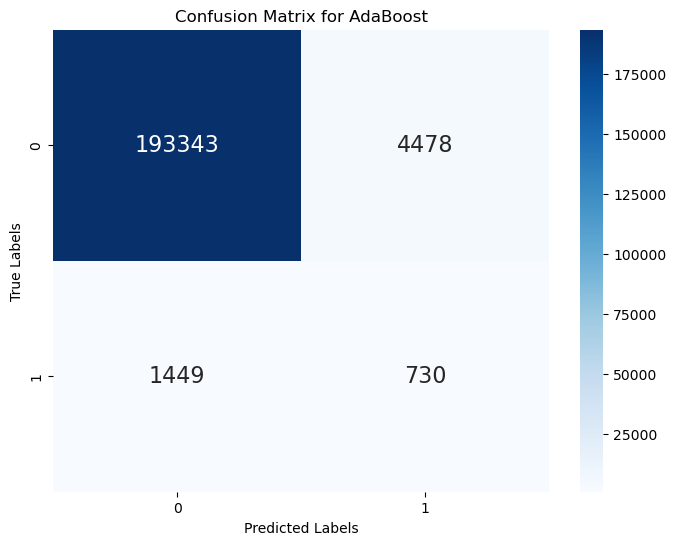

In [16]:
# Computing and visualizing the confusion matrix for AdaBoost

# Compute the confusion matrix for AdaBoost
conf_matrix_adaboost = confusion_matrix(y_test, y_pred_adaboost_adjusted)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adaboost, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for AdaBoost")
plt.show()



193,343 (Verdaderos Negativos - TN): Representa la cantidad de instancias correctamente clasificadas como negativas. Estas son las predicciones acertadas de casos pertenecientes a la clase negativa.

4,478 (Falsos Positivos - FP): Indica el número de instancias incorrectamente clasificadas como positivas cuando en realidad pertenecen a la clase negativa. Estos son los casos de "falsas alarmas" donde el modelo predice positivo incorrectamente.

1,449 (Falsos Negativos - FN): Representa la cantidad de instancias incorrectamente clasificadas como negativas cuando en realidad pertenecen a la clase positiva. Estos son los casos en los que el modelo no logra identificar correctamente las instancias positivas.

730 (Verdaderos Positivos - TP): Indica la cantidad de instancias correctamente clasificadas como positivas. Estas son las predicciones acertadas de casos pertenecientes a la clase positiva.

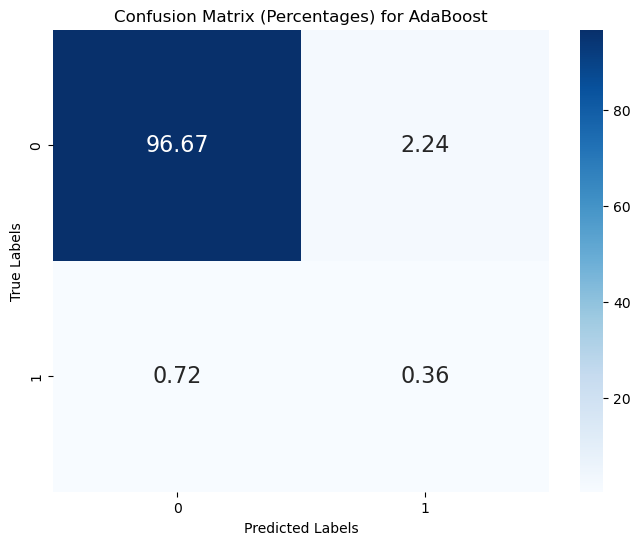

In [17]:
# Visualization of the confusion matrix with percentages for AdaBoost

# Calculate the percentage values for each cell in the confusion matrix
conf_matrix_percent_adaboost = conf_matrix_adaboost / conf_matrix_adaboost.sum() * 100

# Plotting the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_adaboost, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Percentages) for AdaBoost")
plt.show()


96.67% (Porcentaje de Verdaderos Negativos - TN%): Representa la proporción de instancias correctamente clasificadas como negativas en relación con el total de instancias. Es un indicador de la precisión del modelo en predecir correctamente la clase negativa.

2.24% (Porcentaje de Falsos Positivos - FP%): Indica la proporción de instancias incorrectamente clasificadas como positivas en relación con el total de instancias. Muestra la tasa de falsas alarmas del modelo.

0.72% (Porcentaje de Falsos Negativos - FN%): Representa la proporción de instancias incorrectamente clasificadas como negativas en relación con el total de instancias. Indica la tasa de casos positivos que el modelo no logró identificar.

0.36% (Porcentaje de Verdaderos Positivos - TP%): Indica la proporción de instancias correctamente clasificadas como positivas en relación con el total de instancias. Es un indicador de la capacidad del modelo para identificar correctamente la clase positiva.

#### ROC Curve

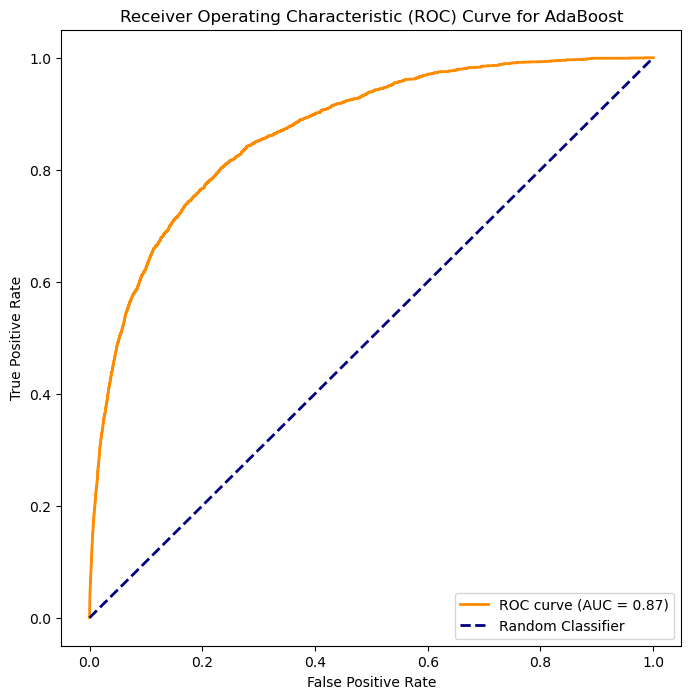

In [18]:
# ROC curve for AdaBoost

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and thresholds for the ROC curve
fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(y_test, y_pred_adaboost[:, 1])

# Calculate the Area Under the Curve (AUC) for the ROC curve
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_adaboost, tpr_adaboost, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_adaboost))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for AdaBoost')
plt.legend(loc='lower right')
plt.show()



Un valor de 0.87 para el Área bajo la Curva ROC (AUC-ROC) es bastante positivo y sugiere que nuestro modelo de clasificación binaria tiene un buen rendimiento en términos de discriminar entre las dos clases.

La Curva ROC evalúa cómo cambia la tasa de verdaderos positivos (recall) en función de la tasa de falsos positivos mientras ajustamos el umbral de clasificación. Un AUC-ROC de 0.87 indica que, en general, nuestro modelo tiene una capacidad bastante robusta para distinguir entre las instancias positivas y negativas.

#### Precision-Recall Curve

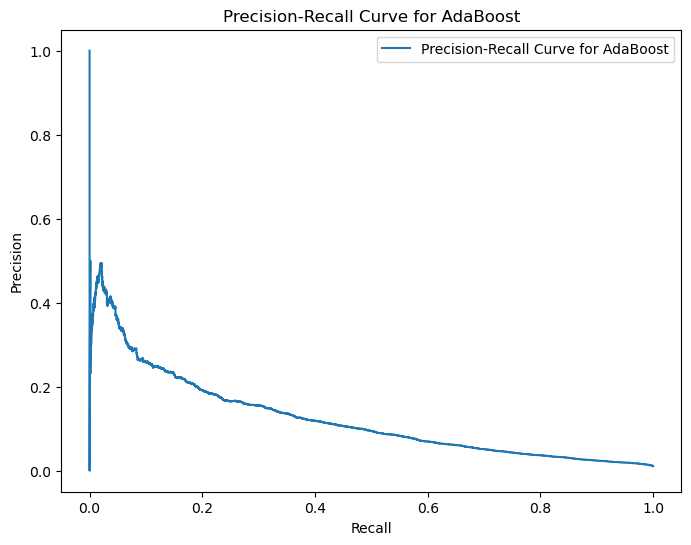

In [19]:
# Precision-recall curve for AdaBoost

# Calculate Precision, Recall, and thresholds for the Precision-Recall curve
precision_adaboost, recall_adaboost, thresholds_adaboost = precision_recall_curve(y_test, y_pred_adaboost[:, 1])

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_adaboost, precision_adaboost, label='Precision-Recall Curve for AdaBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for AdaBoost')
plt.legend()
plt.show()


En una Curva Precisión-Recall, una AUC pequeña indica que el modelo puede tener dificultades para distinguir eficazmente entre las instancias positivas y negativas. Este fenómeno es común cuando hay un desequilibrio marcado entre las clases, es decir, cuando una clase está subrepresentada en comparación con la otra.

Un alto recall a menudo se traduce en un modelo más propenso a clasificar positivamente, lo que resulta en una mayor captura de instancias positivas. Sin embargo, esta estrategia puede llevar a una disminución en la precisión, ya que el modelo podría también clasificar incorrectamente algunas instancias negativas como positivas (falsos positivos). Por otro lado, buscar una alta precisión podría llevar a reducir el recall, ya que el modelo sería más cauteloso al clasificar como positivas solo aquellas instancias para las que tiene una mayor certeza, sacrificando así algunas instancias positivas.

En esta situación con AUC baja y desequilibrio de clases, nos enfrentamos a un dilema delicado de precisión frente a sensibilidad. Debido a ello es necesario ajustar el threshold de clasificación para optimizar el rendimiento del modelo según nuestros objetivos.

En nuestro caso optamos por priorizar el recall frente a la precisión, de esta manera con el threshold seleccionado nos encontramos con un recall proximo a 0,33 y su consiguiente precision, es cierto que con un menor recall se podría obtener más precisión y encontrar un buen equilibrio, pero como hemos comentado, en la realización de este proyecto hemos optado por priorizar la detección de fraude a costa de perder precisión, estamos dispuesto a aumentar nuestra tasa de falsos positivos si con ello conseguimos que nuestro modelo se comporte mejor en la detección del fraude, es decir tenga mejor recall.

#### Cumulative Gain Curve

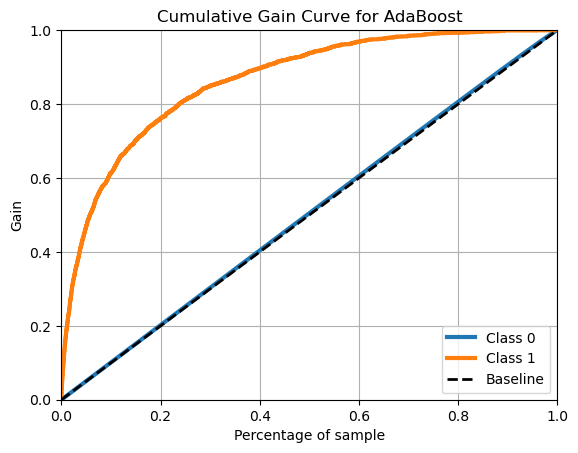

In [20]:
# Cumulative Gain Curve for AdaBoost

# Plot the Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_test, y_pred_adaboost)

# Set the title of the plot
plt.title('Cumulative Gain Curve for AdaBoost')

# Display the plot
plt.show()



La curva de ganancia acumulada es una curva de evaluación que valora el rendimiento del modelo y compara los resultados con la selección aleatoria. Muestra el porcentaje de targets alcanzados cuando se considera un determinado porcentaje de la población con la mayor probabilidad de ser target según el modelo.

En nuestro caso vemos que al considerar el 20% de las instancias con las probabilidades más altas, el modelo identifica aproximadamente el 80% de las instancias positivas (target). Por otro lado, al expandir la evaluación hasta el 60% de las instancias con mayores probabilidades, se alcanza un nivel de identificación del 95% aproximadamente.

Esto indica una eficacia significativa en la identificación temprana de casos positivos. Y a medida que se incluyen más instancias, el modelo no mejora sustancialmente en términos de identificación de casos positivos. Es decir, estos resultados indican que el modelo está siendo efectivo al identificar casos positivos en las instancias con mayores probabilidades. Sin embargo, también sugiere que al considerar un rango más amplio de instancias, el rendimiento no mejora significativamente. 

#### Lift Curve

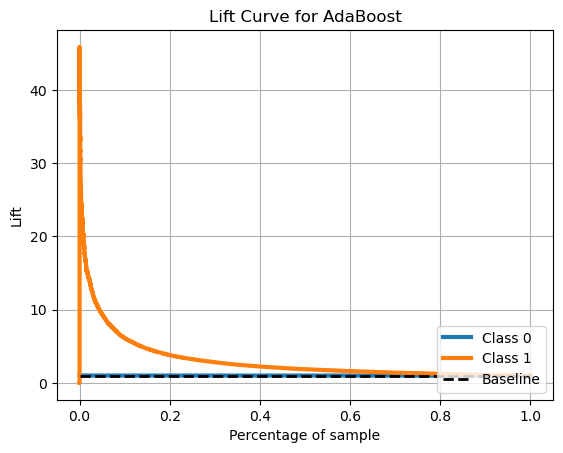

In [21]:
# Lift Curve for AdaBoost using scikit-plot

# Plot the Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_pred_adaboost)

# Set the title of the plot
plt.title('Lift Curve for AdaBoost')

# Display the plot
plt.show()



La curva Lift es una medida del rendimiento de un modelo de selección para predecir o clasificar casos con una respuesta mejorada (para el conjunto de la población), comparado con un modelo de selección aleatoria.

En nuestro caso vemos que la curva está muy próxima a los ejes, si vemos los valores observamos que para el top 10% de observaciones se encuentran un 8% aproximadamente del target. En términos generales la curva tan cercana a los ejes indica que el modelo no proporciona una ventaja sustancial superado el 20% de la muestra en la identificación de observaciones positivas en comparación con un enfoque aleatorio.

In [22]:
import pickle

In [23]:
# Save the training dataset using pickle

# Open a file in binary write mode to save the training dataset
with open('train_best_model.pkl', 'wb') as file:
    # Use pickle to dump the training dataset into the file
    pickle.dump(pd_fraud_train, file)

In [24]:
# Save the test dataset using pickle

# Open a file in binary write mode to save the test dataset
with open('test_best_model.pkl', 'wb') as file:
    # Use pickle to dump the test dataset into the file
    pickle.dump(pd_fraud_test, file)


In [25]:
# Save the AdaBoost model using pickle

# Open a file in binary write mode to save the AdaBoost model
with open('adaboost_best_model.pkl', 'wb') as file:
    # Use pickle to dump the best AdaBoost model into the file
    pickle.dump(random_search_adaboost.best_estimator_, file)